# Frequency filters for denoising

### Setup

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from skimage.restoration import denoise_wavelet

<Axes: >

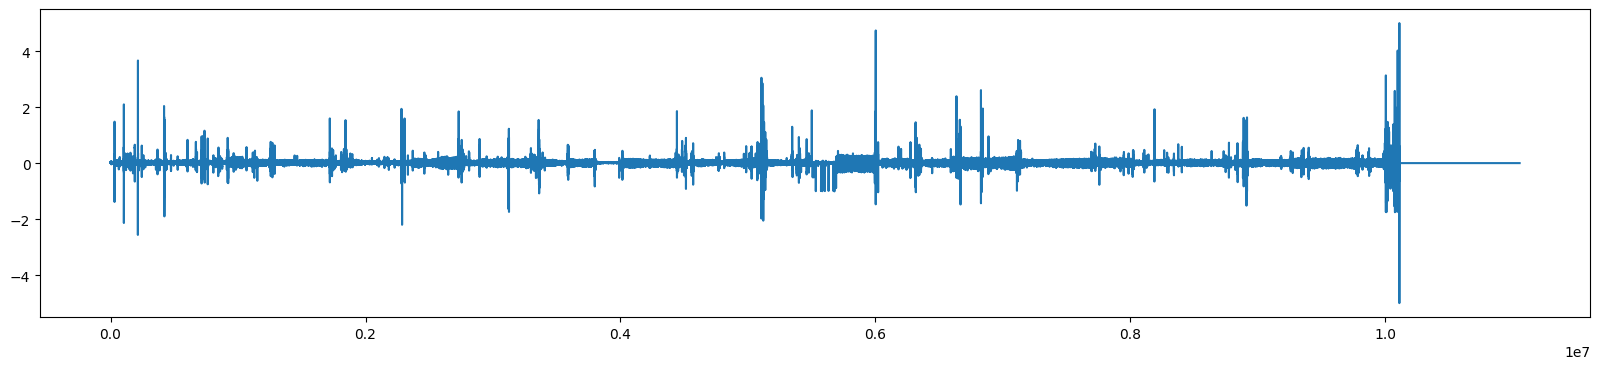

In [2]:
from wearsed.dataset.Recording import Recording
ppg = Recording(1, events_as_list=True).psg['Pleth']

ppg.plot(figsize=(20, 4))

### Frequency filter denoising

In [3]:
def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    y = filtfilt(b, a, data)
    return y

<Axes: >

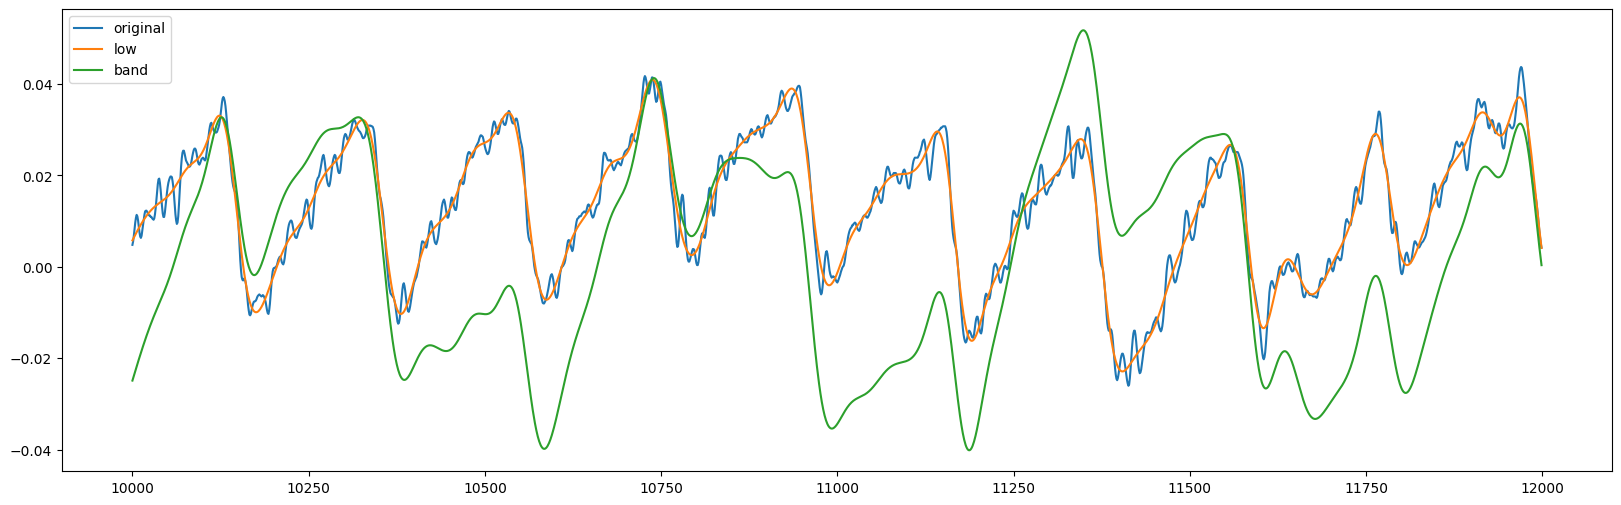

In [4]:
pd.DataFrame({
    'original': ppg,
    'low': butter_lowpass_filtfilt(ppg, 5, 256),
    'band': butter_bandpass_filtfilt(ppg, 0.5, 5, 256)
}).iloc[10000:12000].plot(figsize=(20, 6))

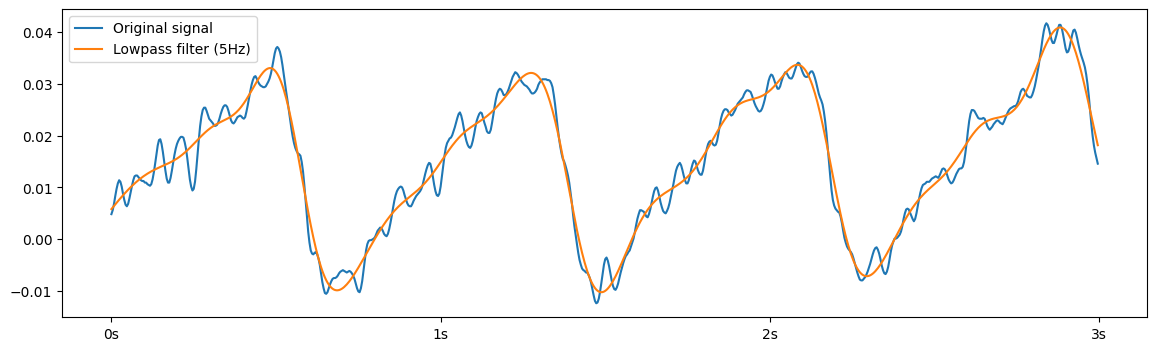

In [18]:
pd.DataFrame({
    'Original signal': ppg,
    'Lowpass filter (5Hz)': butter_lowpass_filtfilt(ppg, 5, 256)
}).iloc[10000:10000+256*3].plot(figsize=(14, 4))
plt.xticks([10000 + i*256 for i in range(4)], [f'{i}s' for i in range(4)]);

### Wavelet denoising

In [35]:
denoised_ppg = denoise_wavelet(ppg, wavelet='db4', mode='soft', wavelet_levels=4, rescale_sigma=True)

In [96]:
# Different Wavelets:
# - Daubechies     *
# - Symlet         *
# - Coiflet        
# - Discrete Meyer * (Discrete alternative to Morlet Wavelet)
# - Biorthogonal   
# - Haar           *
wavelets = ['db4', 'sym5', 'coif3', 'dmey', 'bior3.9', 'haar']
denoised_ppgs = { 'original': ppg }

for wavelet in tqdm(wavelets):
    denoised_ppg = denoise_wavelet(ppg, wavelet=wavelet, mode='soft', wavelet_levels=4, sigma=0.5)
    denoised_ppgs[wavelet] = denoised_ppg

denoised_ppgs = pd.DataFrame(denoised_ppgs)

 67%|██████▋   | 4/6 [00:04<00:02,  1.22s/it]/homes/jwuelfingen/miniconda3/envs/master/lib/python3.12/site-packages/skimage/restoration/_denoise.py:1034: UserWarning: Wavelet thresholding was designed for use with orthogonal wavelets. For nonorthogonal wavelets such as bior3.9,results are likely to be suboptimal.
  out = _wavelet_threshold(
100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


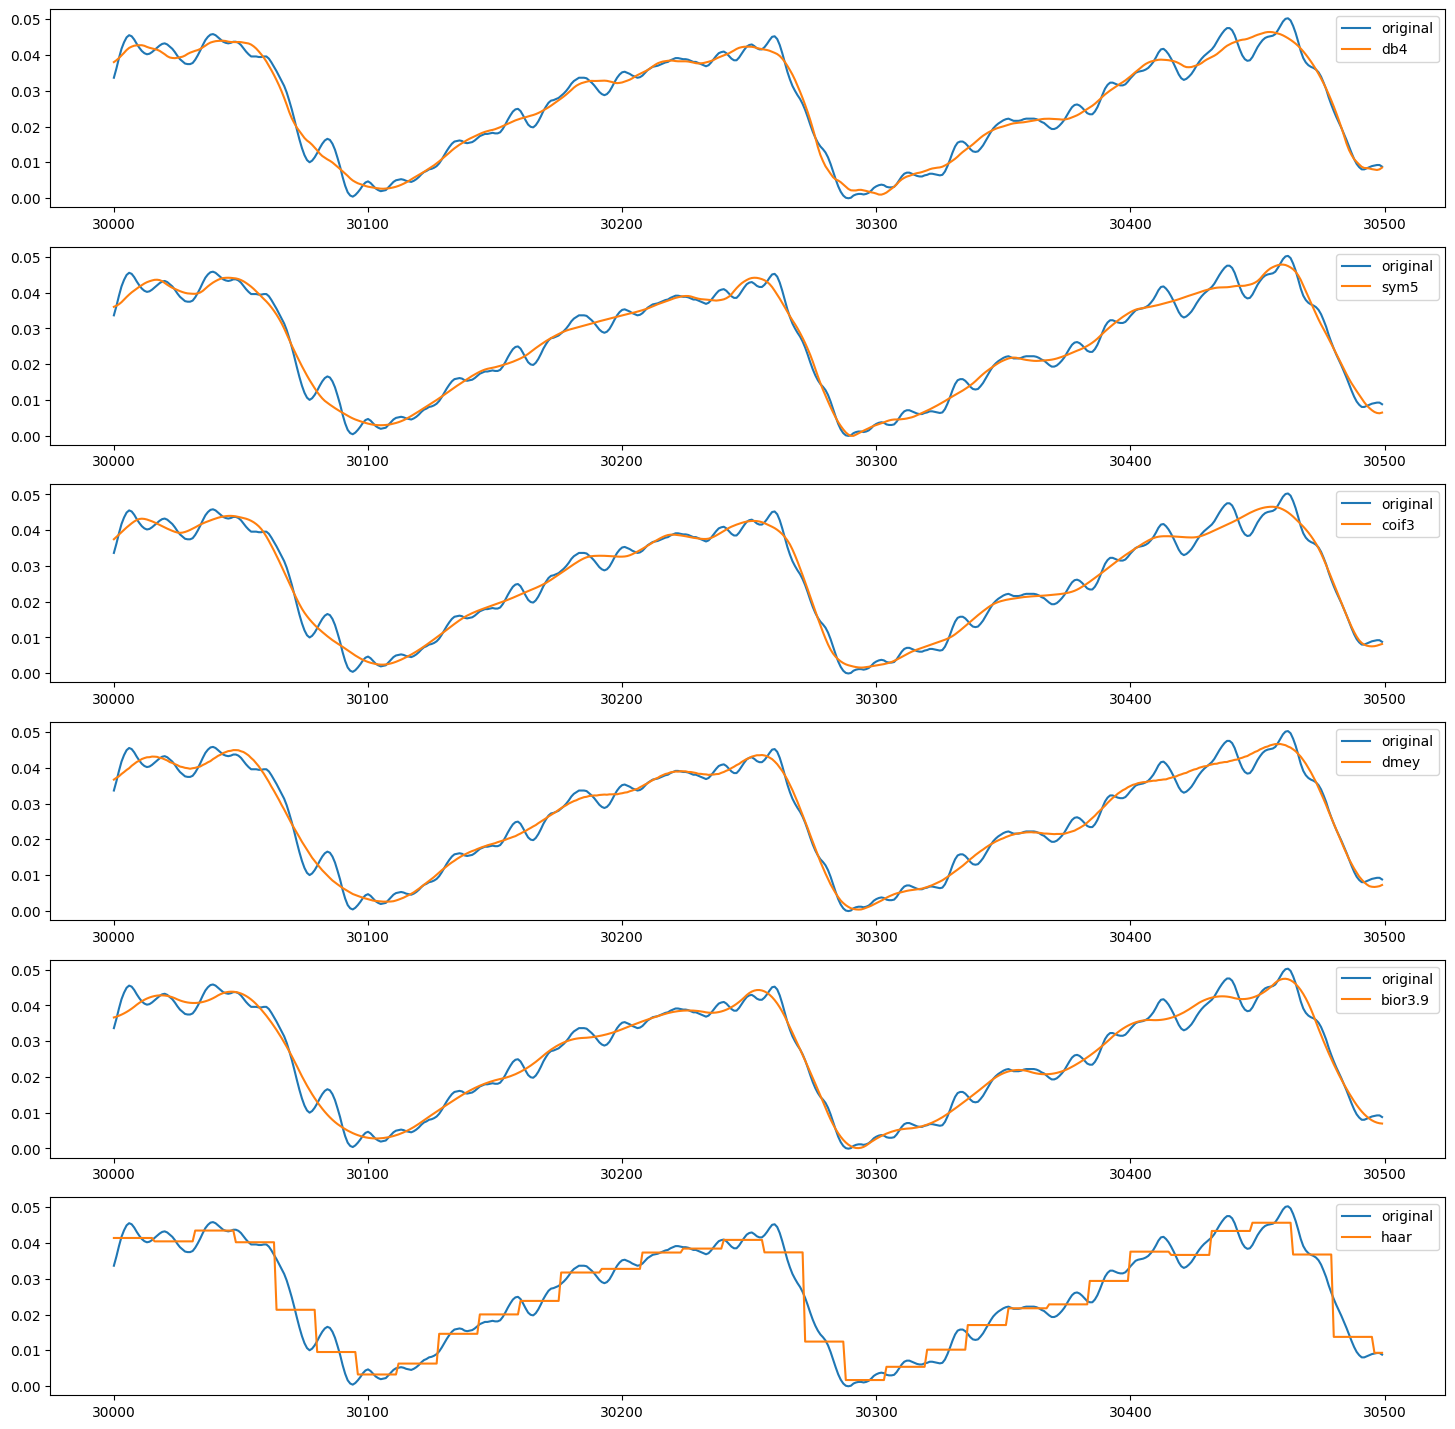

In [97]:
start, duration = 30000, 500
fig, axs = plt.subplots(len(wavelets), 1, figsize=(18, len(wavelets)*3))
for i, wavelet in enumerate(wavelets):
    denoised_ppgs[['original', wavelet]].iloc[start:start+duration].plot(ax=axs[i])

<Axes: >

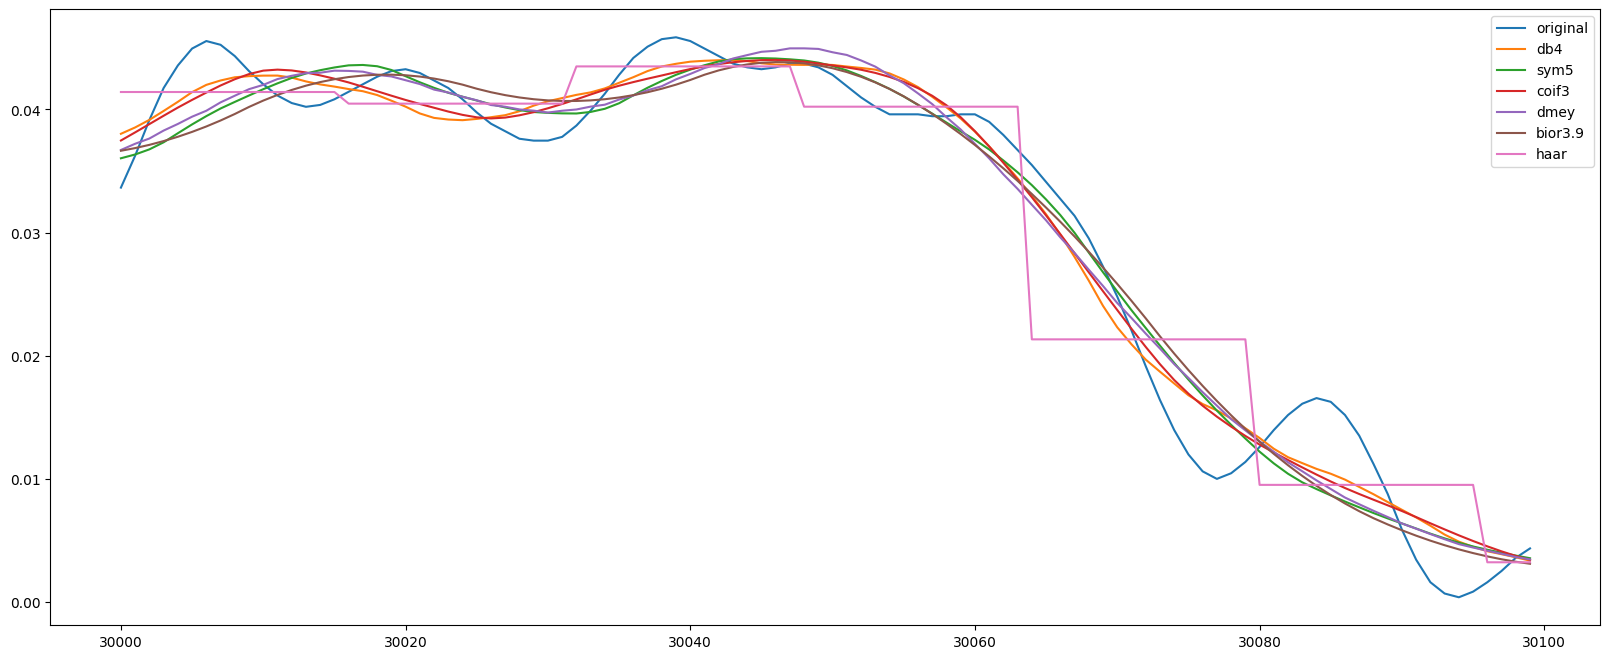

In [93]:
denoised_ppgs.iloc[start:start+100].plot(figsize=(20, 8))

### Hilbert envelope (TODO)